In [176]:
from blackbox37 import check
import string
import random

available_characters = list(string.ascii_uppercase) + [str(i) for i in range(10)]
available_characters.append("")
GROUP_ID = 2

In [120]:
print(available_characters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '']


In [125]:
def generate():
#     size = random.randint(12, 18)
    size = 18
    individual = random.choices(available_characters, k=size)
    while len(individual) < 12:
        individual = random.choices(available_characters, k=size)
    return individual

In [126]:
sol = ''.join(generate())
print(sol)
print(check(group_number=2, attempt=sol))

SDV01S7AUHHPX4GQV
0.44975490196078427


# Population definition

In [153]:
def evaluate(x):
    x['score'] = check(GROUP_ID, x['genotype'])
    return x

def generate_population(size):
    return [{'genotype': generate(), 'score': None} for i in range(size)]


class RandomExploration:
    def evolve(self, pop):
        pop.population = generate_population(len(pop.population))

        
class Population:
    def __init__(self, size, exploration=RandomExploration()):
        self.size = size
        self.population = generate_population(size)
        self.exploration = exploration
        
    def evaluate(self):
        self.population = sorted(map(evaluate, self.population), key=lambda x: x['score'], reverse=True)
        
    def evolve(self):
        self.exploration.evolve(self)
    
    def __str__(self):
        return ''.join(map(lambda x: ''.join(x['genotype']) + f" ({x['score']})\n", self.population)).strip()

### Testing Population

In [128]:
test_pop = Population(3)
test_pop.evaluate()
print(str(test_pop))

A1UZQDT1C1G5OH77UW (0.5220458553791888)
UAMBJKWR1KM4RZLQQ6 (0.4772985705003248)
T9UV7AA52ZYVSKU73 (0.3077731092436975)


# Stratégies d'exploration

In [198]:
def evolve(pop, epochs=5, show_progress=False):
    averages = []
    bests = []
    best = pop.population[0]
    for epoch in range(epochs):
        pop.evaluate()
        b = max(pop.population, key=lambda x: x['score'])
        best = b if b['score'] > best['score'] else best
        bests.append(best['score'])
        average = sum(map(lambda x: x['score'], pop.population)) / pop.size
        averages.append(average)
        if show_progress:
            print(f"Epoch {epoch+1}/{epochs}: Best {''.join(best['genotype'])} ({best['score']}) (average: {average})")
#             print(str(pop))
        pop.evolve()
    return averages, bests, best

In [143]:
population1 = Population(5)
evolve(population1)

------------------------
Epoch 1/5
1EQKWBNUEO0J3NCLO (0.4935383244206774)
J3CFFMYB9B2XJKXWK (0.49264705882352944)
DLV0QGUQ5FZ5IMBSTL (0.4820750237416905)
BBOZZFMJM9VBSL7YO (0.44975490196078427)
XPWNWDMV82T9S8LVH (0.43156604747162025)
------------------------
Epoch 2/5
AX3I3EF0EM5WRG9OWY (0.5012654320987654)
V7N6JL67PW3YDCR1 (0.47222222222222227)
UZG7KMEIPLDWG8UZD7 (0.4611178207192701)
SFYLKO20GLMOGWSOC (0.447730179028133)
VHAMIACXZPCWRDBIL8 (0.44009539842873185)
------------------------
Epoch 3/5
5597LLQBON9NXOIDSD (0.4680918663761801)
MWBED9RSP8KJQGDRVS (0.46593915343915343)
8V7K61MB9EVEB1A0UV (0.445679012345679)
F38TSUB2J0RCDP0LK (0.4355392156862745)
F43A1G5QT113SYPR (0.3680555555555556)
------------------------
Epoch 4/5
CH36F49HHGSMUUG6RR (0.5397673314339982)
L6GBWIXOY3D1H1KC5T (0.5231481481481481)
6DFPUVG285OM2A0STC (0.43937869028448745)
BG9PP558DTBNL0K5 (0.40833333333333344)
6PUXK5JBD42VKAWI (0.3993055555555556)
------------------------
Epoch 5/5
3U7J94FWXSWMHCMKM4 (0.49567901234

In [166]:
def selection(pop, size_bests):
    return pop.population[:size_bests]

def copy_individual(individual):
    return {'genotype': individual['genotype'][:], 'score': individual['score']}

In [162]:
# class CrossOver:
    
class CrossOverRandomTwo:
    def __init__(self, prob):
        self.prob = prob
        
    def __call__(self, bests):
        indiv = random.sample(bests, k=2)
        rand = random.randint(0, 18)
        return {'genotype': indiv[0]['genotype'][:rand] + indiv[1]['genotype'][rand:], 'score': None}

In [184]:
class NCharMutation:
    """
    Mutate n characters in the sequence
    """
    def __init__(self, n):
        self.n = n
        
    def __call__(self, individual):
        charidx_to_mutate = random.choices(range(len(individual['genotype'])), k=self.n)
        
        for idx in charidx_to_mutate:
            individual['genotype'][idx] = random.choice(available_characters)

In [194]:
class SimpleExploration:
    def __init__(self, cross_over, mutation, bests_size=5):
        self.cross_over = cross_over
        self.cross_over = cross_over
        self.mutate = mutation
        self.bests_size = bests_size
        
    def evolve(self, pop):
        new_population = []
        # Get bests individuals
        bests = selection(pop, self.bests_size)
        # Do mutations for the rest of the population
        for i in range(pop.size - self.bests_size): ########################## FIXME Gérer les individus "mort-nés"
            if random.random() < self.cross_over.prob:
                individual = self.cross_over(bests)
            else:
                individual = copy_individual(bests[0]) ############################################# FIXME
            
            self.mutate(individual) # In-place
            new_population.append(individual)
        pop.population = new_population

In [182]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_results(average, bests):
    plt.figure(figsize=(20, 7))
    plt.plot(average, color='green', linestyle='dotted', label='Moyenne de la population actuelle')
    plt.plot(bests, color='red', label='Maximum trouvé')
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="upper left")
    plt.show()

In [196]:
def search(population_size=10, epochs=10):
    cross_over = CrossOverRandomTwo(0.6)
    mutation = NCharMutation(n=2)
    exploration = SimpleExploration(cross_over, mutation)
    
    population = Population(population_size, exploration=exploration)
    averages, bests, best = evolve(population, epochs=epochs, show_progress=True)
    print(f"Best solution found: {''.join(best['genotype'])} ({best['score']})")
    plot_results(averages, bests)

Epoch 1/10: Best 33NXEJY8PGUYXMA2VO (0.5263352120236178) (average: 0.44661103636417165)
Epoch 2/10: Best ZR7DOBKWCEZKO93GFU (0.5578703703703702) (average: 0.25506891162262)
Epoch 3/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.26850240808574144)
Epoch 4/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.25785772869106205)
Epoch 5/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.24585422897017098)
Epoch 6/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.25671390013495277)
Epoch 7/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.23748381218747347)
Epoch 8/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.26695707542276165)
Epoch 9/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.2666705072342327)
Epoch 10/10: Best 339XSJM8PGUYXMA2FU (0.5589981006647674) (average: 0.24663325804630154)
Best solution found: 339XSJM8PGUYXMA2FU (0.5589981006647674)


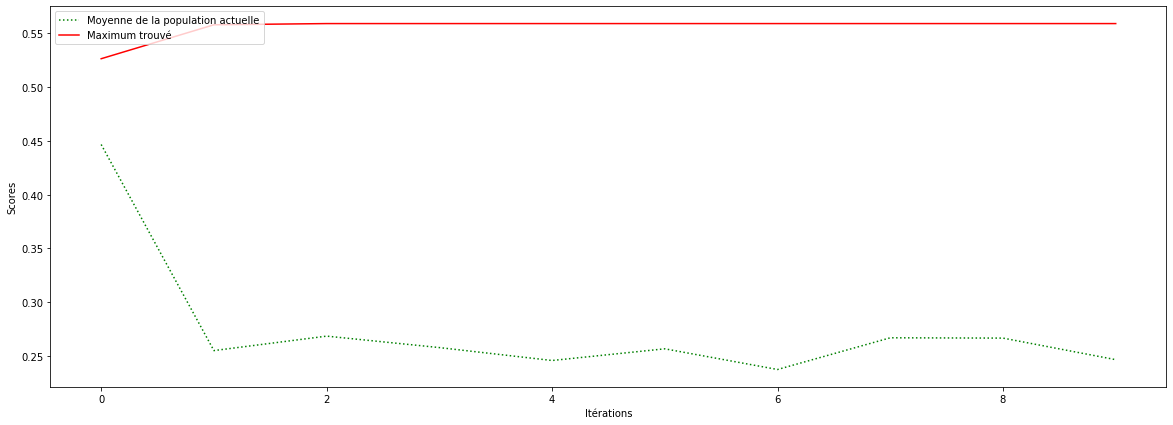

In [199]:
search()